In [1]:
# Uninstall existing xformers and torch to avoid conflicts
!pip uninstall -y xformers torch torchvision torchaudio

# Install a compatible set of libraries
# This command installs PyTorch, torchvision, and torchaudio for CUDA 12.4
!pip install torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --extra-index-url https://download.pytorch.org/whl/cu124

# Install the compatible xformers version
# The version 0.0.29.post2 is known to be compatible with PyTorch 2.6.0
!pip install xformers==0.0.29.post2

# Verify the installation
!python -c "import torch; print(f'Torch version: {torch.__version__}')"
!python -c "import xformers; print(f'xformers version: {xformers.__version__}')"

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [2]:
# Install necessary libraries for the project
!pip install diffusers transformers accelerate torch torchvision --quiet
!pip install peft --quiet

# Import standard libraries
import os
import torch
import pandas as pd
from google.colab import drive
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from diffusers.optimization import get_scheduler
from peft import LoraConfig, get_peft_model
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
from IPython.display import display

# Try installing xformers specifically for the torch version we have
XFORMERS_AVAILABLE = False
try:
    print("Attempting to install xformers...")
    !pip install -U xformers --quiet

    # Check if xformers is actually working and compatible
    try:
        from xformers.ops import memory_efficient_attention
        XFORMERS_AVAILABLE = True
        print("✅ XFormers installed and compatible.")
    except ImportError:
        print("❌ XFormers installed but failed to import. Continuing without it.")
        pass # XFormers couldn't be imported, so we proceed without it.

except Exception as e:
    print(f"❌ XFormers installation failed: {e}")

print("--- Setup Complete ---")

Attempting to install xformers...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━

In [3]:
# Print versions of key libraries
import torch
import torchvision
import diffusers
import transformers
import accelerate
import peft
import xformers

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"diffusers version: {diffusers.__version__}")
print(f"transformers version: {transformers.__version__}")
print(f"accelerate version: {accelerate.__version__}")
print(f"peft version: {peft.__version__}")
print(f"xformers version: {xformers.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
diffusers version: 0.34.0
transformers version: 4.55.0
accelerate version: 1.10.0
peft version: 0.17.0
xformers version: 0.0.29.post2


In [4]:
# Mount Google Drive to access your dataset and save the model
drive.mount('/content/drive')

# Define the paths for your Flicker8k dataset
# NOTE: Update this path to where your Flicker8k dataset is located on your Google Drive.
# The PDF references a dataset structure with a root folder, so adapt this accordingly.
flicker_dataset_path = '/content/drive/MyDrive/ImageCaptioning'
flicker_images_path = os.path.join(flicker_dataset_path, 'Images')
flicker_captions_file = os.path.join(flicker_dataset_path, 'captions.txt')

print("--- Dataset paths configured ---")

Mounted at /content/drive
--- Dataset paths configured ---


In [5]:
import os
import pandas as pd

# Define the path to your captions.txt file
flicker_dataset_path = '/content/drive/MyDrive/ImageCaptioning'
flicker_captions_file = os.path.join(flicker_dataset_path, 'captions.txt')

print("--- Preparing metadata.csv for Flicker8k dataset using pandas ---")

try:
    # Read the file using pandas, specifying the comma separator
    metadata_df = pd.read_csv(flicker_captions_file, sep=',')

    # Print the columns to verify their names
    print(f"Columns after reading file: {metadata_df.columns.tolist()}")

    # Remove the caption ID from the image column.
    # We use the original column name 'image' to perform the split.
    metadata_df['image'] = metadata_df['image'].apply(lambda x: x.split('#')[0])

    # Add a descriptive prefix to the caption column.
    metadata_df['caption'] = metadata_df['caption'].apply(lambda c: f"a photograph of a scene, {c}")

    # Rename the 'image' column to 'file_name' for consistency with the rest of the project.
    metadata_df.rename(columns={'image': 'file_name'}, inplace=True)

    # Save the cleaned DataFrame to a new metadata.csv file.
    metadata_df.to_csv(os.path.join(flicker_dataset_path, 'metadata.csv'), index=False)

    print(f"--- Created metadata.csv with {len(metadata_df)} entries for Flicker8k dataset ---")
    print("\nFirst 5 entries of the created metadata.csv:")
    print(metadata_df.head())

except FileNotFoundError:
    print("Error: captions.txt not found. Please check your path.")
except Exception as e:
    print(f"An unexpected error occurred: {e}. Please check your file's separator.")

--- Preparing metadata.csv for Flicker8k dataset using pandas ---
Columns after reading file: ['image', 'caption']
--- Created metadata.csv with 40455 entries for Flicker8k dataset ---

First 5 entries of the created metadata.csv:
                   file_name  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a photograph of a scene, A child in a pink dre...  
1  a photograph of a scene, A girl going into a w...  
2  a photograph of a scene, A little girl climbin...  
3  a photograph of a scene, A little girl climbin...  
4  a photograph of a scene, A little girl in a pi...  


In [6]:
# Define the custom dataset class
class FlickerDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.captions_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Filter out any corrupted or missing images
        valid_entries = []
        for idx in range(len(self.captions_df)):
            img_path = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        img.verify() # Check if image is valid
                    valid_entries.append(idx)
                except:
                    continue
        self.captions_df = self.captions_df.iloc[valid_entries].reset_index(drop=True)
        print(f"Found {len(self.captions_df)} valid images")

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
        try:
            image = Image.open(img_name).convert("RGB")
        except:
            # Return a black image if there's an issue
            image = Image.new('RGB', (512, 512), (0, 0, 0))

        caption = self.captions_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}

# Image transformations
preprocess = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Create a limited dataset for efficient training
max_training_images = 1000
metadata_df = pd.read_csv(os.path.join(flicker_dataset_path, 'metadata.csv'))
print(f"Total images available: {len(metadata_df)}")

# Randomly sample max_training_images if we have more than that
if len(metadata_df) > max_training_images:
    limited_metadata = metadata_df.sample(n=max_training_images, random_state=42).reset_index(drop=True)
    print(f"Using {max_training_images} randomly selected images")
else:
    limited_metadata = metadata_df
    print(f"Using all {len(metadata_df)} images")

# Save the limited metadata to a temporary file
limited_metadata_path = os.path.join(flicker_dataset_path, 'limited_metadata.csv')
limited_metadata.to_csv(limited_metadata_path, index=False)

# Create the dataset with the limited metadata
train_dataset = FlickerDataset(
    csv_file=limited_metadata_path,
    image_dir=flicker_images_path,
    transform=preprocess
)

# Create the training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
print(f"Training dataloader created with {len(train_dataloader)} batches")

Total images available: 40455
Using 1000 randomly selected images
Found 1000 valid images
Training dataloader created with 1000 batches


In [7]:
# Model and training configuration
pretrained_model_name = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/drive/MyDrive/ImageGenerator/Flickr_model"
os.makedirs(output_dir, exist_ok=True)

# Training parameters
learning_rate = 1e-5
num_train_epochs = 3
train_batch_size = 1
gradient_accumulation_steps = 4

# Calculate total training steps
total_steps = len(train_dataloader) * num_train_epochs
print(f"Total training steps: {total_steps}")
print("--- Loading pretrained model ---")

# Load the pipeline with better error handling
try:
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False,
        use_safetensors=True
    )
except Exception as e:
    print(f"Error loading with safetensors, trying without: {e}")
    pipeline = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )

# Move components to CUDA
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to("cuda", dtype=torch.float16)
vae = pipeline.vae.to("cuda", dtype=torch.float16)
unet = pipeline.unet.to("cuda", dtype=torch.float16)
scheduler = pipeline.scheduler

# Enable memory efficient attention if XFormers is available
try:
    if XFORMERS_AVAILABLE:
        unet.enable_xformers_memory_efficient_attention()
        print("XFormers memory efficient attention enabled")
    else:
        unet.set_attention_slice("auto")
        print("Using attention slicing for memory efficiency")
except Exception as e:
    print(f"Memory optimization not available: {e}")
    print("Continuing with standard attention")

print("--- Model loaded successfully ---")

Total training steps: 3000
--- Loading pretrained model ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

XFormers memory efficient attention enabled
--- Model loaded successfully ---


In [8]:
print("--- Setting up LORA ---")

# Freeze the original parameters
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Configure LORA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "to_k",
        "to_q",
        "to_v",
        "to_out.0",
        "ff.net.0.proj",
        "ff.net.2",
    ],
)
lora_dropout = 0.1

# Apply LoRA to UNet
unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Setup optimizer for LoRA parameters only
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate, weight_decay=1e-2)

# Learning rate scheduler
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_dataloader) * num_train_epochs,
)
print("--- LORA setup complete ---")

--- Setting up LORA ---
trainable params: 5,984,256 || all params: 865,505,220 || trainable%: 0.6914
--- LORA setup complete ---


In [9]:
print("--- Starting Training ---")

# Enable gradient checkpointing for memory efficiency
unet.enable_gradient_checkpointing()
# Set models to appropriate modes
vae.eval()
text_encoder.eval()
unet.train()
global_step = 0
max_train_steps = len(train_dataloader) * num_train_epochs

# Training loop
for epoch in range(num_train_epochs):
    print(f"--- Epoch {epoch + 1}/{num_train_epochs} ---")
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    for step, batch in enumerate(progress_bar):
        # Convert images to latent space
        with torch.no_grad():
            latents = vae.encode(batch["image"].to("cuda", dtype=torch.float16)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()

        # Add noise to the latents according to the noise magnitude at each timestep
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        with torch.no_grad():
            encoder_hidden_states = text_encoder(
                tokenizer(
                    batch["caption"],
                    padding="max_length",
                    max_length=tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt"
                ).input_ids.to("cuda")
            )[0]

        # Get the target for loss depending on the prediction type
        if scheduler.config.prediction_type == "epsilon":
            target = noise
        elif scheduler.config.prediction_type == "v_prediction":
            target = scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss detected at step {global_step}, skipping...")
            continue

        # Backpropagation
        loss.backward()

        # Gradient clipping and optimizer step
        if (global_step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.detach().item()})

        # Log progress.
        if global_step % 100 == 0:
            print(f"Step {global_step}, Loss: {loss.detach().item():.4f}")

        global_step += 1

    print(f"Epoch {epoch + 1} completed")

print("--- Training Finished ---")

--- Starting Training ---
--- Epoch 1/3 ---


Epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Step 0, Loss: 0.9490
Step 100, Loss: 0.2956
Step 200, Loss: 0.2105
Step 300, Loss: 0.0221
Step 400, Loss: 0.0104
Step 500, Loss: 0.4897
Step 600, Loss: 0.0261
Step 700, Loss: 0.4226
Step 800, Loss: 0.0292
Step 900, Loss: 0.4995
Epoch 1 completed
--- Epoch 2/3 ---


Epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Step 1000, Loss: 0.1935
Step 1100, Loss: 0.0808
Step 1200, Loss: 0.1864
Step 1300, Loss: 0.0326
Step 1400, Loss: 0.3511
Step 1500, Loss: 0.1210
Step 1600, Loss: 0.4140
Step 1700, Loss: 0.1838
Step 1800, Loss: 0.0133
Step 1900, Loss: 0.7012
Epoch 2 completed
--- Epoch 3/3 ---


Epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Step 2000, Loss: 0.3157
Step 2100, Loss: 0.3489
Step 2200, Loss: 0.2877
Step 2300, Loss: 0.0067
Step 2400, Loss: 0.1543
Step 2500, Loss: 0.0222
Step 2600, Loss: 0.3458
Step 2700, Loss: 0.0909
Step 2800, Loss: 0.0469
Step 2900, Loss: 0.0106
Epoch 3 completed
--- Training Finished ---


--- Setting up inference pipeline---
--- Testing the fine-tuned model ---

Generating image for: 'A man in a red jacket holding a dog on a leash.'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_A_man_in_a_red_jacket_holding_a_dog_on_a_leash.png


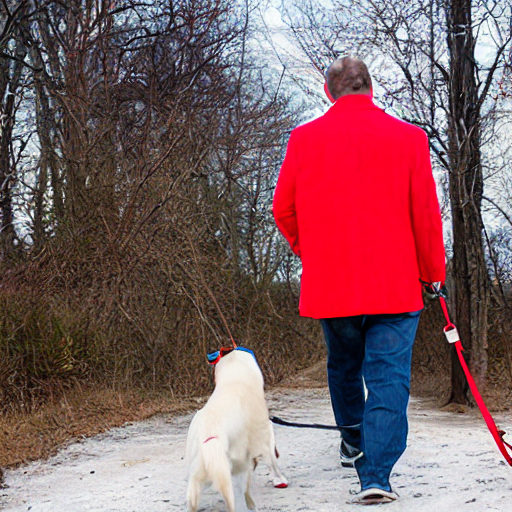


Generating image for: 'A young girl sitting on a park bench.'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_A_young_girl_sitting_on_a_park_bench.png


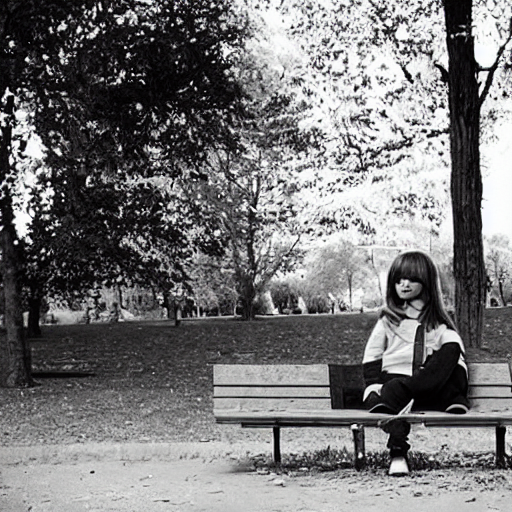


Generating image for: 'A close-up shot of a group of dogs playing in a field.'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_A_close-up_shot_of_a_group_of_dogs_playing_in_a_field.png


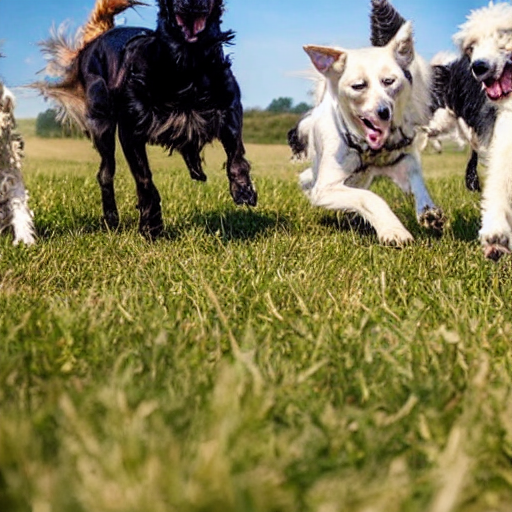


Generating image for: 'A group of people sitting at a cafe table.'


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: /content/generated_A_group_of_people_sitting_at_a_cafe_table.png


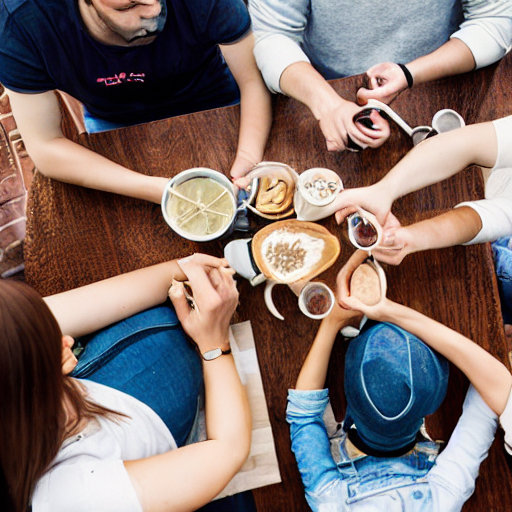

--- Testing completed ---
TRAINING AND TESTING COMPLETE!

Are you satisfied with the results and want to save the model? (y/n): y
--- Saving the fine-tuned model ---
Model saved to /content/drive/MyDrive/ImageGenerator/Flickr_model


In [10]:
print("--- Setting up inference pipeline---")
# Set model to evaluation mode
unet.eval()

# Function to generate images using the original pipeline approach
def generate_flicker_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        # Use the original pipeline but replace the unet with our fine-tuned one
        original_unet = pipeline.unet
        pipeline.unet = unet
        try:
            # Generate image
            image = pipeline(
                prompt,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=torch.manual_seed(42) # For reproducible results
            ).images[0]
            return image
        finally:
            # Restore the original unet
            pipeline.unet = original_unet

# Alternative method if the above doesn't work
def generate_flicker_image_manual(prompt, num_inference_steps=50, guidance_scale=7.5):
    """Manual image generation without pipeline reconstruction"""
    with torch.no_grad():
        # Encode the prompt
        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        text_embeddings = text_encoder(text_inputs.input_ids.to("cuda"))[0]

        # Create unconditional embeddings for classifier-free guidance
        uncond_inputs = tokenizer(
            "",
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = text_encoder(uncond_inputs.input_ids.to("cuda"))[0]

        # Combine embeddings
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Generate random latents
        latents = torch.randn((1, unet.config.in_channels, 64, 64), device="cuda", dtype=torch.float16)
        latents = latents * scheduler.init_noise_sigma

        # Set timesteps
        scheduler.set_timesteps(num_inference_steps)
        timesteps = scheduler.timesteps

        # Denoising loop
        for t in timesteps:
            # Expand latents for classifier-free guidance
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

            # Predict noise
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings,
                return_dict=False
            )[0]

            # Perform classifier-free guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Compute the previous noisy sample
            latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

        # Decode latents to image
        latents = 1 / vae.config.scaling_factor * latents
        image = vae.decode(latents, return_dict=False)[0]

        # Convert to PIL image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])

        return image

# Test the model
print("--- Testing the fine-tuned model ---")
test_prompts = [
    "A man in a red jacket holding a dog on a leash.",
    "A young girl sitting on a park bench.",
    "A close-up shot of a group of dogs playing in a field.",
    "A group of people sitting at a cafe table."
]

for prompt in test_prompts:
    print(f"\nGenerating image for: '{prompt}'")
    try:
        # Try the pipeline method first
        generated_image = generate_flicker_image(prompt)
        # Save the image
        safe_filename = prompt.split(',')[0].replace(' ', '_').replace('.', '').replace('/', '')
        image_path = f"/content/generated_{safe_filename}.png"
        generated_image.save(image_path)
        print(f"Image saved to: {image_path}")
        #Display in Colab
        display(generated_image)
    except Exception as e:
        print(f"Pipeline method failed: {str(e)}")
        print("Trying manual generation method...")
        try:
            # Try manual method as fallback
            generated_image = generate_flicker_image_manual(prompt)
            #Save the image
            safe_filename = prompt.split(',')[0].replace(' ', '_').replace('.', '').replace('/', '')
            image_path = f"/content/generated_manual_{safe_filename}.png"
            generated_image.save(image_path)
            print(f"Image saved to: {image_path}")
            # Display in Colab
            display(generated_image)
        except Exception as e2:
            print(f"Manual method also failed: {str(e2)}")

print("--- Testing completed ---")

# Save the model
print("="*60)
print("TRAINING AND TESTING COMPLETE!")
print("="*60)
save_model = input("\nAre you satisfied with the results and want to save the model? (y/n): ")
if save_model.lower() == 'y':
    print("--- Saving the fine-tuned model ---")
    #Save the LORA weights
    unet.save_pretrained(output_dir)
    #Save the tokenizer and text encoder configuration
    tokenizer.save_pretrained(output_dir)
    #Save a simple info file about the model
    info_text = f"""Flicker8k Generator Model
    Training completed with:
    {len(train_dataset)} images
    {num_train_epochs} epochs
    LORA fine-tuning
    To load this model later:
    1. Load the base model: runwayml/stable-diffusion-v1-5
    2. Load the LORA weights from: {output_dir}
    3. Apply LORA to the UNet
    """
    with open(os.path.join(output_dir, "model_info.txt"), "w") as f:
        f.write(info_text)

    print(f"Model saved to {output_dir}")

In [13]:
%%writefile app.py
import gradio as gr
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch
import os
from huggingface_hub import hf_hub_download

# ---------- CONFIG ----------
BASE_MODEL = "runwayml/stable-diffusion-v1-5"
# Change this to your Hugging Face Hub repository where you will upload your LoRA
LORA_FLICKER_HUB_REPO = "Khatijaliya/flicker8k-lora"
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# Fixed inference parameters for optimal performance
INFERENCE_STEPS = 8
GUIDANCE_SCALE = 5

# Global variable for the pipeline
active_pipeline = None

# ---------- MODEL LOADING FUNCTION ----------
def load_model():
    """Load the base model and fine-tuned LoRA weights"""
    global active_pipeline

    print("Loading base Stable Diffusion model...")
    try:
        # Load the base model
        pipe = StableDiffusionPipeline.from_pretrained(
            BASE_MODEL,
            torch_dtype=torch_dtype,
            use_safetensors=True,
            safety_checker=None,
            requires_safety_checker=False
        )

        # Load LoRA weights from the Hub
        print(f"Loading LoRA weights from {LORA_FLICKER_HUB_REPO}...")
        pipe.load_lora_weights(LORA_FLICKER_HUB_REPO)

        # Use a faster scheduler
        pipe.scheduler = EulerDiscreteScheduler.from_config(
            pipe.scheduler.config,
            use_karras_sigmas=True
        )

        pipe.to(device)

        # Enable memory optimizations
        if hasattr(pipe, "enable_attention_slicing"):
            pipe.enable_attention_slicing(1)
            print(" Attention slicing enabled")

        if hasattr(pipe, "enable_vae_slicing"):
            pipe.enable_vae_slicing()
            print(" VAE slicing enabled")

        # Enable xFormers if available
        if hasattr(pipe, "enable_xformers_memory_efficient_attention"):
            try:
                pipe.enable_xformers_memory_efficient_attention()
                print(" xFormers memory efficient attention enabled")
            except Exception as e:
                print(f" xFormers not available: {e}")

        active_pipeline = pipe
        print(f" Model loaded successfully on {device}")
        return True

    except Exception as e:
        print(f" Error loading model: {e}")
        return False

# ---------- GENERATION FUNCTION ----------
def generate_image(prompt, seed, progress=gr.Progress()):
    """Generate image using the active pipeline with optimized settings"""

    if active_pipeline is None:
        return None, " Model not loaded! Please reload the app."

    if not prompt or prompt.strip() == "":
        return None, " Please enter a prompt!"

    try:
        progress(0.1, desc="Preparing generation...")

        # Set up generator
        if seed == -1:
            generator = torch.Generator(device=device)
        else:
            generator = torch.Generator(device=device).manual_seed(int(seed))

        progress(0.3, desc="Generating image...")

        # Generate with fixed optimized settings
        with torch.inference_mode():
            if device == "cuda":
                with torch.autocast(device_type="cuda", dtype=torch_dtype):
                    result = active_pipeline(
                        prompt=prompt,
                        num_inference_steps=INFERENCE_STEPS,
                        guidance_scale=GUIDANCE_SCALE,
                        generator=generator,
                        return_dict=True
                    )
            else:
                result = active_pipeline(
                    prompt=prompt,
                    num_inference_steps=INFERENCE_STEPS,
                    guidance_scale=GUIDANCE_SCALE,
                    generator=generator,
                    return_dict=True
                )

        progress(1.0, desc="Complete!")

        info = f" Generated successfully!\nOptimized Settings - Steps: {INFERENCE_STEPS}, Guidance: {GUIDANCE_SCALE}"
        if seed != -1:
            info += f", Seed: {seed}"

        return result.images[0], info

    except Exception as e:
        return None, f" Generation failed: {str(e)}"

# ---------- BUILD UI ----------
def create_interface():
    """Create the Gradio interface with a single generation page"""

    with gr.Blocks(title="Flicker8k Image Generator", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# Flicker8k Image Generator")
        gr.Markdown("Fine-tuned on the Flicker8k dataset to generate images of people, animals, and outdoor scenes.")

        with gr.Row():
            with gr.Column(scale=1):
                prompt = gr.Textbox(
                    label="Describe the image you want",
                    placeholder="e.g., A person walking a dog on a path, high quality photograph",
                    lines=3
                )
                seed = gr.Number(
                    value=-1,
                    label="Seed (-1 for random)",
                    info="Use the same seed to reproduce results"
                )

                # Add this markdown component for the explanation
                gr.Markdown("""
                <br>
                ### What is 'Seed'?
                The 'seed' is a number that acts as a starting point for the image generation process.

                - **When you use a fixed seed (e.g., `42`),** the model will produce the exact same image every time you use the same prompt.
                - **When you use `-1`,** the model chooses a random seed, so each time you generate, you will get a different, unique image.
                """)

                btn_generate = gr.Button("Generate Image", variant="primary", size="lg")

            with gr.Column(scale=1):
                output_img = gr.Image(label="Generated Image", type="pil")
                generation_info = gr.Markdown("")

        btn_generate.click(
            generate_image,
            inputs=[prompt, seed],
            outputs=[output_img, generation_info]
        )

    return demo

# ---------- MAIN ----------
if __name__ == "__main__":
    print(" Starting Flicker8k Image Generator...")

    # Initialize model
    if not load_model():
        print(" Failed to load model. The app cannot run.")
        exit(1)

    # Create and launch interface
    demo = create_interface()
    demo.launch()

Overwriting app.py


In [12]:
%%writefile requirements.txt
torch==2.6.0
diffusers
transformers
accelerate
peft
gradio
xformers

Overwriting requirements.txt


In [10]:
from huggingface_hub import notebook_login
from huggingface_hub import create_repo, upload_folder

# Login to Hugging Face (you will be prompted to enter your token)
notebook_login()

# Set your Hugging Face username and space name
your_username = "Khatijaliya"
space_name = "flicker8k-generator"
space_id = f"{your_username}/{space_name}"

# Create the Space (run this only once)
create_repo(repo_id=space_id, repo_type="space", space_sdk="gradio", private=False)

# Upload the current directory (including app.py and requirements.txt) to your Space
upload_folder(
    repo_id=space_id,
    folder_path=".",        # Current directory
    path_in_repo=".",       # Upload everything to root
    repo_type="space"
)

print(f"Your Space is live at: https://huggingface.co/spaces/{space_id}")

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-689f72df-4b9034cd0283eeb841fd2132;58cfcebd-db60-4179-8b32-9ae3cc3765c4)

You already created this space repo

Your Space is live at: https://huggingface.co/spaces/Khatijaliya/flicker8k-generator